# No Free Lunch Theorem
* ConvNet makes an assumption on the locality & the stationarity of images: http://cs231n.github.io/convolutional-networks/#fc
* Fully-Connected Networks don't
## In this notebook we will look at the MNIST dataset:
* Compare ConvNet & Fully-Connected NNs
* Compare them when the image is scrambled

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

## Load MNIST Dataset
* Use the torchvision to import the dataset (pre-installed)

In [47]:
from torchvision import datasets, transforms # loads the data
import torch.optim as optim

In [30]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)



Processing...
Done!


In [32]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

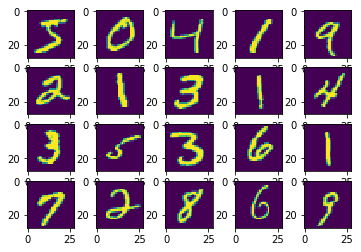

In [37]:
# show some images
plt.figure()
for i in range(20):
    plt.subplot(4, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

## Create models

In [55]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 labels
## Fully connected NN
class FC2Layer(nn.Module):
    def __init__(self, input_size,n_hidden, output_size):
        super(FC2Layer,self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,output_size),
            nn.LogSoftmax()
        )
    def forward(self, x):
        x = x.view(-1,self.input_size)
        return self.network(x)

    
## Convolutional NN   
class Convnet(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(Convnet,self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(1, n_feature,kernel_size= 5)
        self.conv2 = nn.Conv2d(n_feature,n_feature,kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10) # as 10 classes
        
    def forward(self, x, verbose =False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x)
        return x  

## Lets define train and test modules:

In [50]:
accuracy_list = list()

def train(epoch, model, perm = torch.arange(0,784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)    
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx%100==0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


def test(model, perm = torch.arange(0,784).long()):
    model.eval()
    test_loss=0
    correct=0
    for data, target in test_loader:
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))     

In [56]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Lets Train Fully Connected NN: 

In [58]:
n_hidden    = 8    # number of hidden units

model = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.346742


/Users/aniruddhkhera/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.733334
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.052513
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.911037
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.459352
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.462092
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.763353
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.423212
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.213144
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.826156

Test set: Average loss: 0.4273, Accuracy: 8747/10000 (87%)



## Now lets train a ConvNet

In [60]:
# Training settings 
n_features    = 6     # number of feature maps

model = Convnet(input_size, n_features, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.343176


/Users/aniruddhkhera/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.947776
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.718957
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.333277
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.455609
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.253750
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.234527
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.151014
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.257708
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.152878

Test set: Average loss: 0.1755, Accuracy: 9456/10000 (95%)

